#  Прогнозирование заказов такси

**Постановка задачи:**
Компания такси собрала исторические данные о заказах машин в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Цель:**
Разработка системы предсказания объема заказа.

**План работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

**Инструменты:**

Машинное обучение, Pandas, Python, Scikit-learn, statsmodels

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score)
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
taxi = pd.read_csv('/content/taxi.csv')

In [5]:
taxi.head(3)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
taxi.index = taxi['datetime']
taxi = taxi.drop('datetime', axis=1)
taxi.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [10]:
taxi.sort_index(inplace=True)
taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [11]:
taxi.tail(3)

,num_orders
datetime,
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [12]:
taxi.index.duplicated().sum()

0

**Вывод:** Датасет представляет собой данные о заказах 26496 в хронологическом порядке с шагом 10 минут, дубликаты отсутствуют

## Анализ

### Ресемплирование данных

Решила ресемплировать данные для анализа по часу, дням, по неделям и по месяцам

In [13]:
taxi_hour = taxi.resample('1H').sum()
taxi_hour.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [14]:
taxi_day = taxi.resample('1D').sum()
taxi_day.head(3)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290


In [15]:
taxi_week = taxi.resample('1W').sum()
taxi_week.head(3)

,num_orders
datetime,
2018-03-04,5301
2018-03-11,9411
2018-03-18,9785


In [16]:
taxi_month = taxi.resample('1M').sum()
taxi_month

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


### Анализ данных по месяцам

**Note:** Сначала проанализирую количество заказов по месяцам

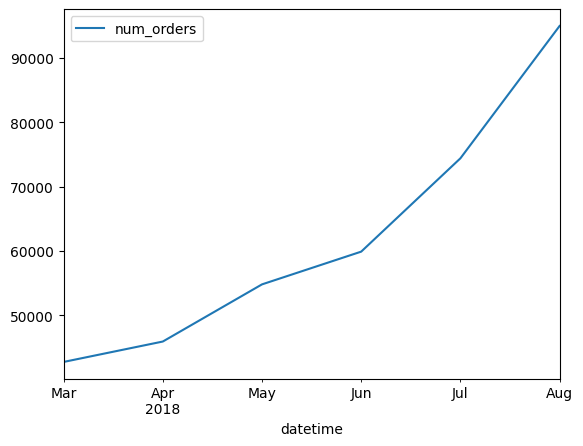

In [17]:
taxi_month.plot()
plt.show()

**Вывод:** График заказов по месяцам показывает тренд роста общего количества заказов в месяц

### Анализ данных по дням недели

Решила проанализировать общее количество заказов по дням недели, где 0 -это понедельник, а 6 - воскресенье

In [18]:
taxi_dayofweek = taxi_day.copy()
taxi_dayofweek['weekday'] = taxi_dayofweek.index.weekday

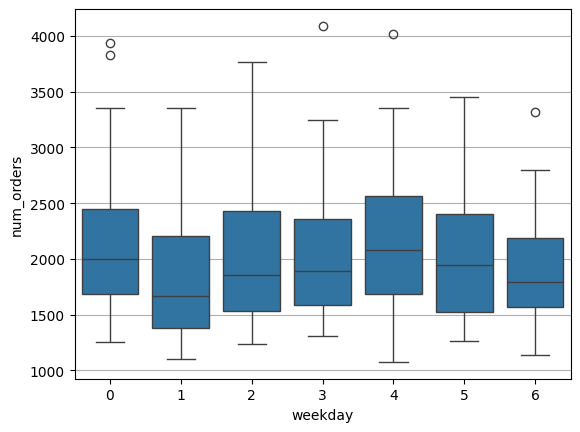

In [19]:
fig, ax = plt.subplots()
sns.boxplot(data=taxi_dayofweek, x='weekday', y='num_orders', ax=ax)
ax.yaxis.grid(True)
plt.show()

**Вывод:** По медиане видно, что большее количество заказов приходится на понедельник и пятницу, минимальное количество заказов во вторник и воскресенье

Решила проанализировать ряд в рамках одного случайно выбранного месяца

In [20]:
taxi_april = taxi_day['2018-04-01':'2018-04-30']

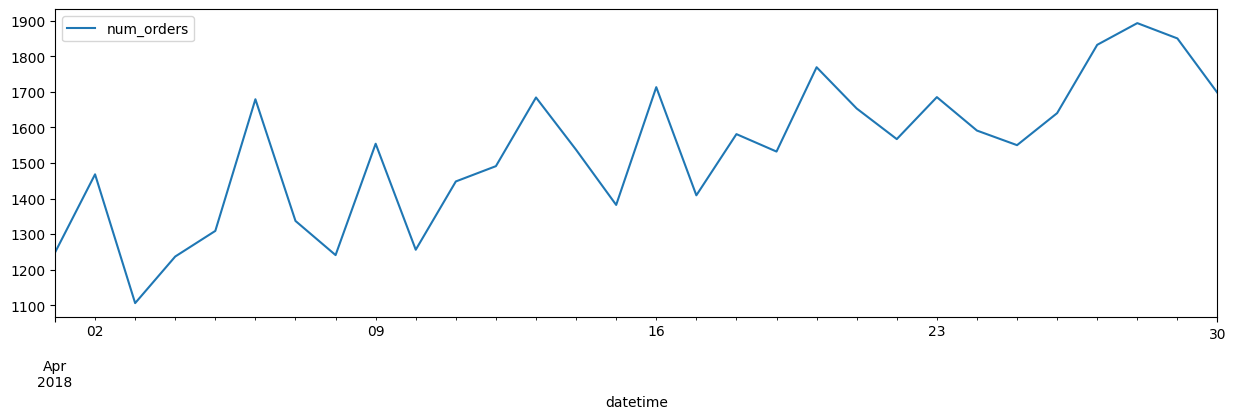

In [21]:
plt.figure(figsize=(15,4))
taxi_april.plot(ax=plt.gca())
plt.show()

In [22]:
decomposed_taxi_april = seasonal_decompose(taxi_april)

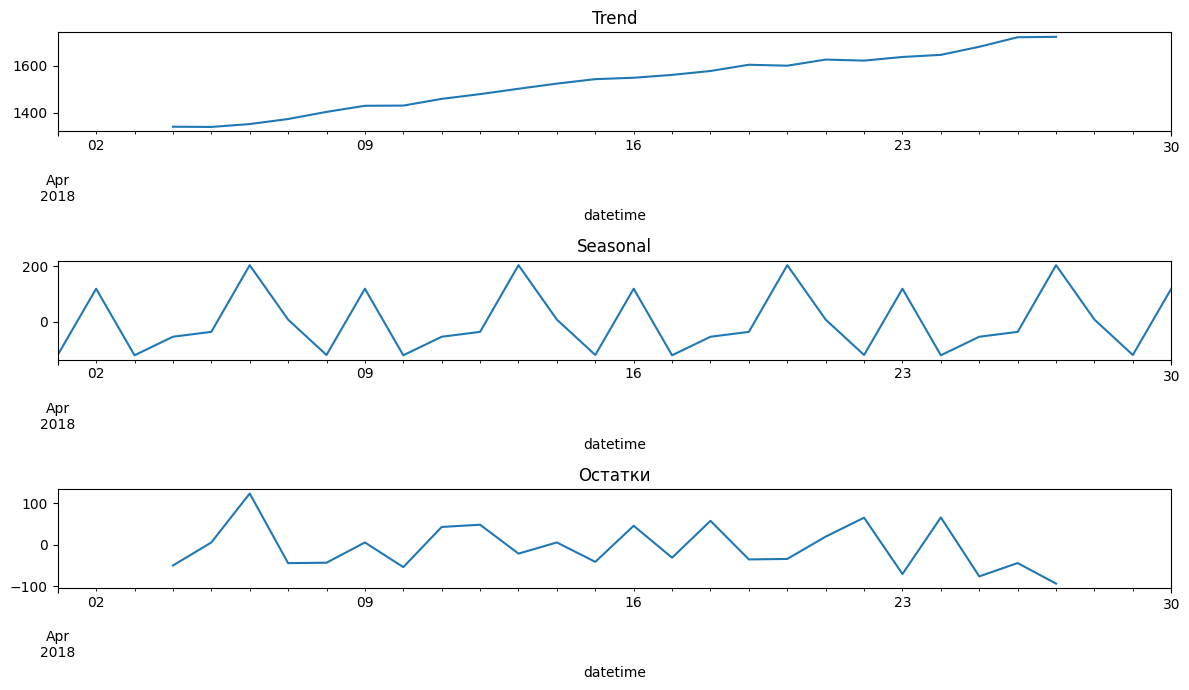

In [23]:
plt.figure(figsize=(12,7))
plt.subplot(311)

decomposed_taxi_april.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_taxi_april.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)

decomposed_taxi_april.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()

plt.show()

**Вывод:** За 4 недели апреля отчетливо виден тренд роста. Видна сезонность данных - есть всплески количества заказов по понедельникам и пятницам

### Анализ данных по дням

Решила провести тест Дики Фуллера для проверки временного ряда на стационарность

In [24]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(taxi_day, regression='ctt')
print('Статистика: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

Статистика:  0.39598609719374456
p-value:  0.999325166524547
Critical values:  {'1%': -4.440603286586607, '5%': -3.8675856674129863, '10%': -3.5749831445145532}
есть единичные корни, ряд не стационарен


**Вывод:** Проведенный тест подтвердил предположения о не стационарности ряда.

In [25]:
decomposed_taxi_day = seasonal_decompose(taxi_day)

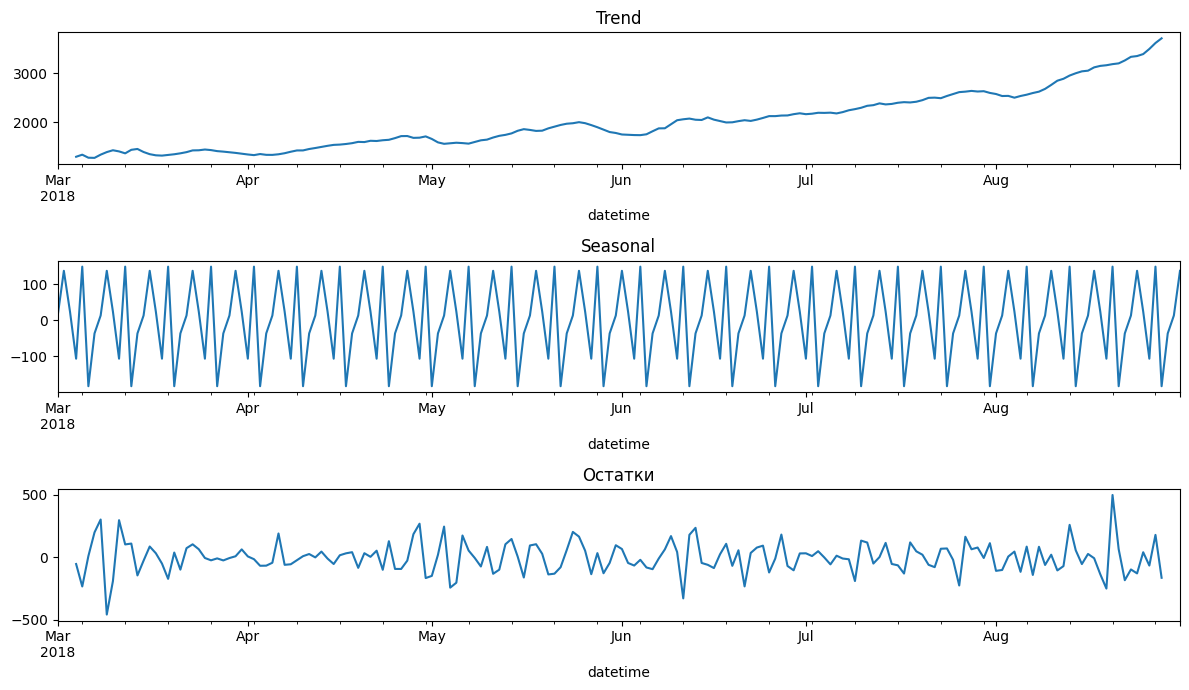

In [26]:
plt.figure(figsize=(12,7))
plt.subplot(311)

decomposed_taxi_day.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_taxi_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)

decomposed_taxi_day.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()

plt.show()

**Вывод:** При анализе данных по дням виден тренд роста количества заказов и отчетливо видна сезонность внутри каждого месяца

Скользящее среднее

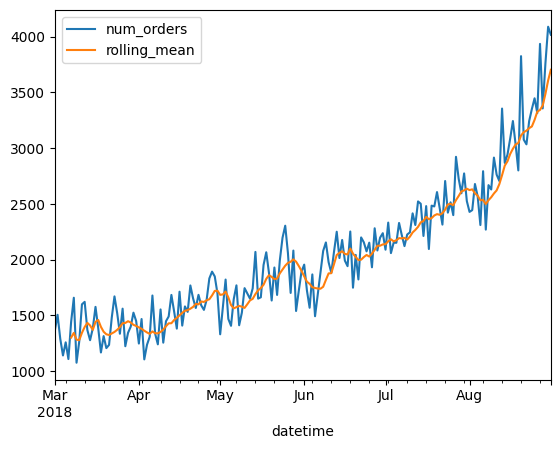

In [27]:
taxi_day['rolling_mean'] = taxi_day.rolling(7).mean()
taxi_day.plot()
plt.show()

**Вывод:** как и в анализе по месяцам тренд показывает постепенное увеличение количества заказов. Так же видна сезонность заказов по дням в пределах месяца

Разности временного ряда

In [28]:
taxi_day = taxi_day.drop('rolling_mean', axis=1)

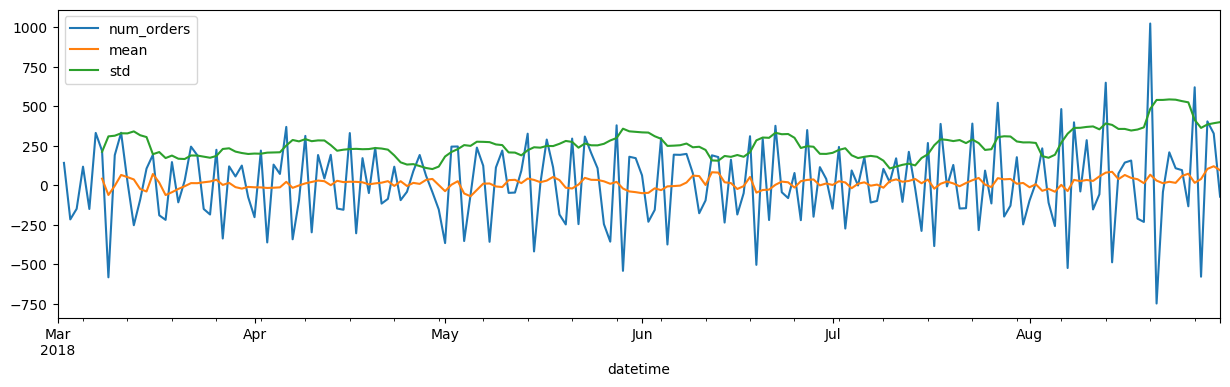

In [29]:
plt.figure(figsize=(15,4))
taxi_day = taxi_day - taxi_day.shift()
taxi_day['mean'] = taxi_day['num_orders'].rolling(7).mean()
taxi_day['std'] = taxi_day['num_orders'].rolling(7).std()
taxi_day.plot(ax=plt.gca())
plt.show()

**Вывод:** При применении разницы временного ряда, скользящее среднее с шагом в 7 дней ряд показывает более стационарный ряд

### Анализ данных по часам

возьму данные за 1 неделю, чтобы проанализировать часовые тенденции.

In [30]:
taxi_7_days = taxi_hour['2018-05-01':'2018-05-07']

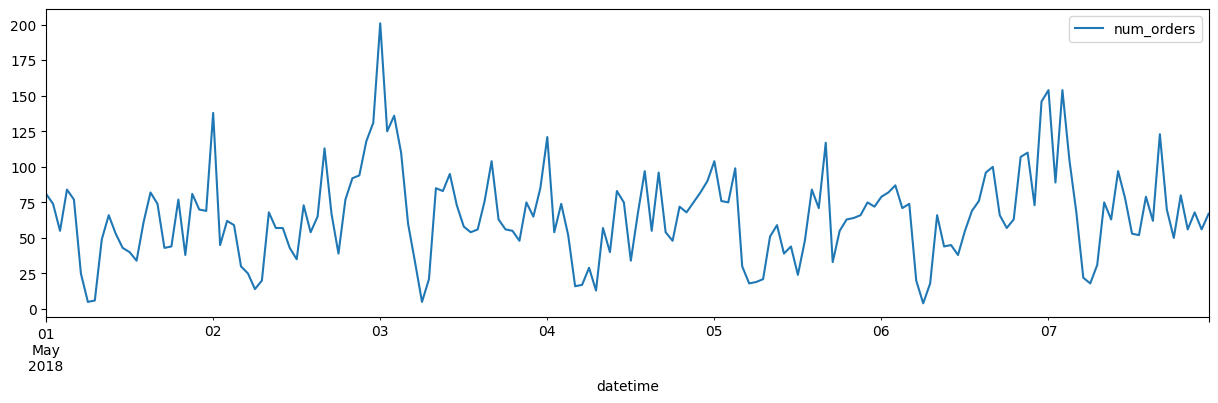

In [31]:
plt.figure(figsize=(15,4))
taxi_7_days.plot(ax=plt.gca())
plt.show()

In [32]:
decomposed_taxi_7_days = seasonal_decompose(taxi_7_days)

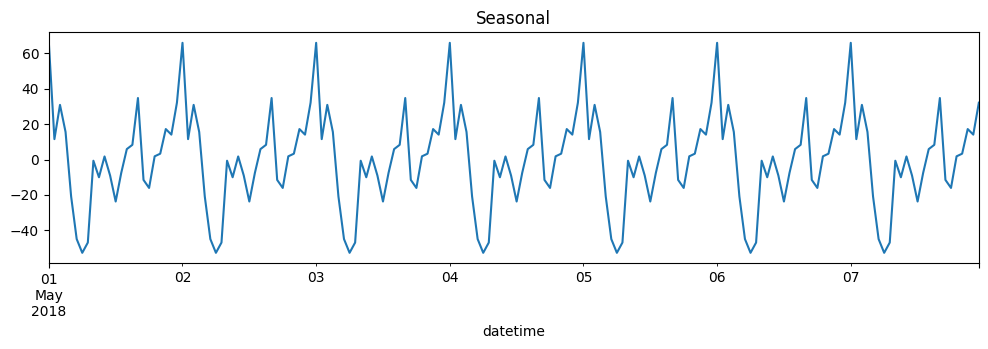

In [33]:
plt.figure(figsize=(12,3))

decomposed_taxi_7_days.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.show()

**Вывод:** При анализе часовых тенденций за неделю видны всплески количества заказов в 0 часов каждого дня, проанализирую более подробно в срезе 3х дней.

In [34]:
taxi_3_days = taxi_hour['2018-06-01':'2018-06-03']

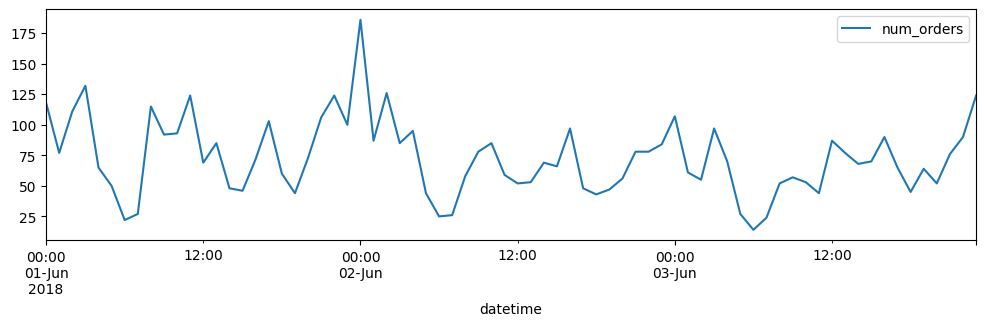

In [35]:
plt.figure(figsize=(12,3))
taxi_3_days.plot(ax=plt.gca())
plt.show()

In [36]:
decomposed_taxi_3_days = seasonal_decompose(taxi_3_days)

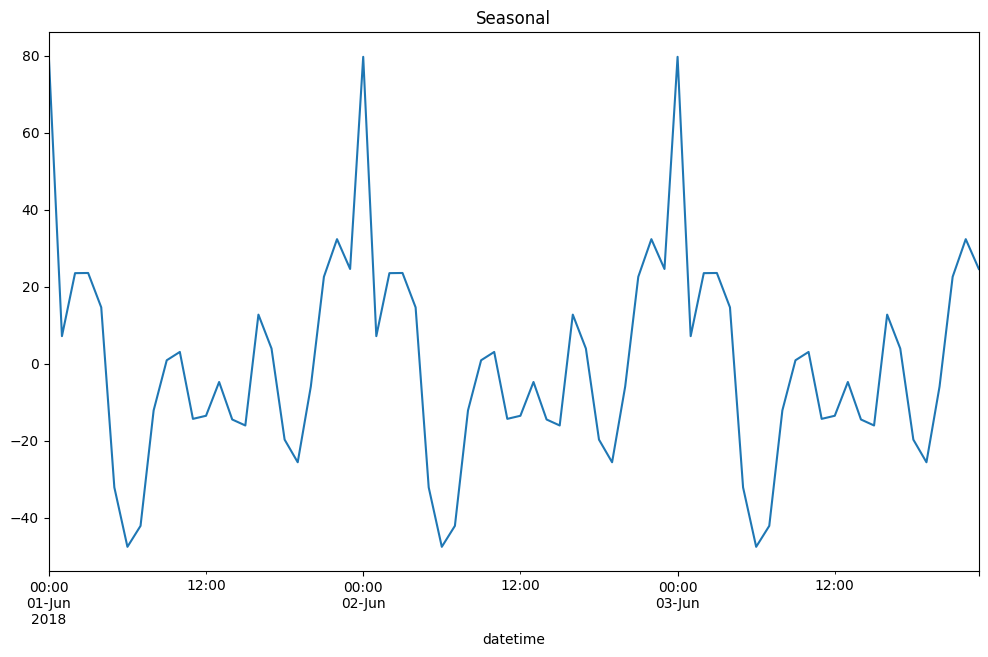

In [37]:
plt.figure(figsize=(12,7))

decomposed_taxi_3_days.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.show()

**Вывод:** При анализе часовых тенденций за 3 дня видны всплески количества заказов в 0 часов каждого дня

## Обучение

### Подготовка признаков для модели

Для обучения буду использовать данные ресемплированные по часам, добавлю в датасет календарные признаки и признак выходного дня

Так как в данных обнаружена сезонность по часам, следует добавить данные с лагом от 12 часов до 24 часов и 7*24 для недельной сезонности

Скользящее среднее решила добавить с шагом в 48 часов для покрытия колебаний дней

In [38]:
def make_features(data_1, lag_start, lag_end, rolling_mean_size):
    data = data_1.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['is_weekend'] = data.dayofweek.isin([5,6])*1

    for lag in range(lag_start, lag_end):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['lag_7days'] = data['num_orders'].shift(7*24)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data


taxi_hour_f = make_features(taxi_hour, 12, 24, 48)
taxi_hour_f.tail()

,num_orders,day,dayofweek,hour,is_weekend,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_7days,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,31,4,19,0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,113.0,170.895833
2018-08-31 20:00:00,154,31,4,20,0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,179.0,170.208333
2018-08-31 21:00:00,159,31,4,21,0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,166.0,169.437500
2018-08-31 22:00:00,223,31,4,22,0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,242.0,169.208333
2018-08-31 23:00:00,205,31,4,23,0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,173.0,170.166667


### Разделение на выборки

При разделении на тестовую и тренировочную выборку очень важно не перемешивать данные, а оставить из в хронологическом порядке

In [39]:
train,test = train_test_split(taxi_hour_f, test_size=0.1, shuffle=False)
train = train.dropna()

print(train.shape)
print(test.shape)

(3806, 19)
(442, 19)


In [40]:
train_target = train['num_orders']
train_features = train.drop('num_orders', axis=1)
test_target = test['num_orders']
test_features = test.drop('num_orders', axis=1)

### Кодирование качественных признаков

Для линейной регрессии необходимо закодировать качественные признаки

In [41]:
ohe_features = ['day','dayofweek', 'hour', 'is_weekend']

train_features_scaled = train_features.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train_features_scaled[ohe_features])

# добавление закодированных признаков
train_features_scaled[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_features_scaled[ohe_features])

# удаление незакодированных изначальных колонок
train_features_scaled = train_features_scaled.drop(ohe_features, axis=1)

In [42]:
train_features_scaled.shape

(3806, 74)

Кодирование тестовой выборки

In [43]:
test_features_scaled = test_features.copy()
# добавление закодированных признаков
test_features_scaled[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_features_scaled[ohe_features])

# удаление незакодированных изначальных колонок
test_features_scaled = test_features_scaled.drop(ohe_features, axis=1)

### Обучение модели линейной регресии

Так же для временных рядов не подходит разбивка на случайные подвыборки, которая применятся обычно для перекрёстного поиска. Есть специальный класс, который формирует последовательные подвыборки, не нарушая порядок расположения наблюдений. То есть, чтобы модель не могла заглянуть в будущее. Создадим такой объект.

In [44]:
tscv = TimeSeriesSplit(n_splits=5)

In [45]:
model_lrg = LinearRegression()

In [46]:
param_grid = {'fit_intercept' : [True, False], 'normalize' : [True, False]}

In [47]:
lrg_grid_cv = GridSearchCV(
    model_lrg, param_grid, scoring ='neg_root_mean_squared_error', cv=tscv, n_jobs=-1
)

lrg_grid_cv.fit(train_features_scaled, train_target)

print(f'Наилучшая RMSE: {(-1)*round(lrg_grid_cv.best_score_, 3)}')
print(f'Наилучшие параметры: {lrg_grid_cv.best_params_}')

Наилучшая RMSE: 29.274
Наилучшие параметры: {'fit_intercept': False, 'normalize': True}


In [48]:
best_params = lrg_grid_cv.best_params_
model_lrg = LinearRegression(**best_params)

In [49]:
model_lrg.fit(train_features_scaled,train_target)

LinearRegression(fit_intercept=False, normalize=True)

**Вывод:** На кросс-валидации модель Линейной регрессии показала результат RMSE = 29,27 с параметрами fit_intercept = False и normalize = True

### Обучение модели градиентным бустингом из LightGBM

In [50]:
categorical_feature = ['day','dayofweek', 'hour', 'is_weekend']

In [51]:
parameters_grid_lgbm = {
    'n_estimators': range(80, 120, 10),
    'boosting_type': ['gbdt', 'dart']
}

lgbm = LGBMRegressor(random_state=12345)

lgbm_grid_cv = GridSearchCV(
    lgbm, parameters_grid_lgbm, scoring ='neg_root_mean_squared_error', cv=tscv, n_jobs=-1
)

lgbm_grid_cv.fit(train_features, train_target, categorical_feature=categorical_feature)

print(f'Наилучшая RMSE: {(-1)*round(lgbm_grid_cv.best_score_, 3)}')
print(f'Наилучшие параметры: {lgbm_grid_cv.best_params_}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 18
[LightGBM] [Info] Start training from score 79.352864
Наилучшая RMSE: 25.037
Наилучшие параметры: {'boosting_type': 'gbdt', 'n_estimators': 80}


In [52]:
best_params_lgbm = lgbm_grid_cv.best_params_

In [53]:
lgbm_best = LGBMRegressor(random_state=12345, **best_params)

In [54]:
lgbm_best.fit(train_features, train_target, categorical_feature=categorical_feature)

[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 18
[LightGBM] [Info] Start training from score 79.352864


LGBMRegressor(fit_intercept=False, normalize=True, random_state=12345)

**Вывод:** Модель градиентного бустинга показала хороший результат RMSE = 25.037 на кросс-валидации.

Лучше результат показала модель градиентного бустинга. Следует проверить ее на тестовой выборке

## Тестирование

In [55]:
test_predictions = lgbm_best.predict(test_features)

[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: fit_intercept


In [56]:
rmse_test = mean_squared_error(test_target, test_predictions, squared = False)
print(f'Результат RMSE модели LGBM на тестовой выборке: {round(rmse_test,3)}')

Результат RMSE модели LGBM на тестовой выборке: 43.41


In [57]:
importances = lgbm_best.feature_importances_

In [58]:
importances

array([307,  81, 286,   7, 162, 117, 128, 127, 151, 144, 142, 188, 173,
       117, 153, 181, 252, 284], dtype=int32)

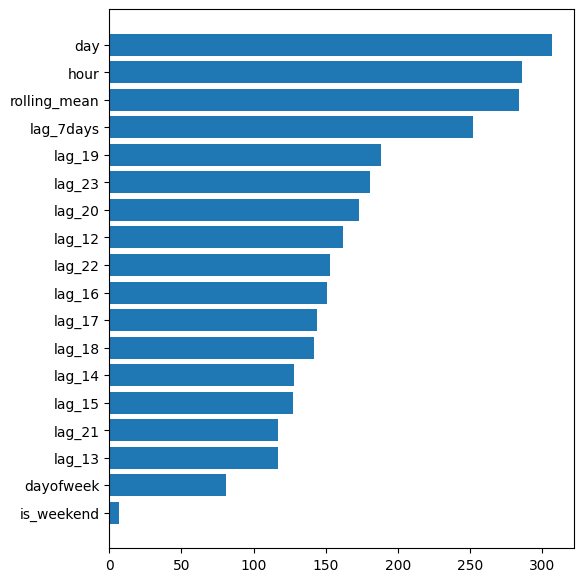

In [59]:
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(6, 7))

bar_width = 0.8
ax.barh(range(len(importances)), importances[indices], height=bar_width)

ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(test_features.columns)[indices])
plt.show()

**Вывод:** Модель LightGBM удовлетворяет запросу клиента, показывая на тестовой выборке результат RMSE =43,41. Для визуализации результата я вывела рейтинг признаков на которые опиралась модель в предсказании.
Самыми важными для модели оказались признаки дня и часа, что как раз отражает сезонность, скользящее среднее, которое формирует более стационарный ряд и lag 7 дней.

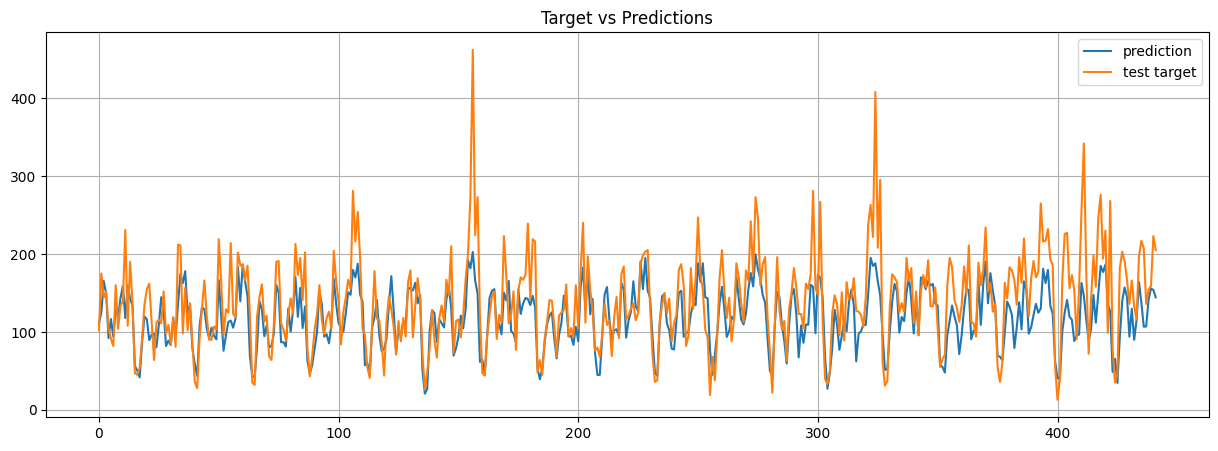

In [60]:
plt.figure(figsize=(15, 5))
plt.plot(test_predictions, label="prediction")
plt.plot(list(test_target), label="test target")
plt.axis('tight')
plt.title('Target vs Predictions')
plt.grid(True)
plt.legend()
plt.show()

**Вывод:** Модель не достаточно хорошо отработала аномальные скачки, но показала результат в рамках заказанной погрешности.

## Вывод

**Подведем итоги:**

Датасет представляет собой данные о заказах 26496 в хронологическом порядке с шагом 10 минут.

*Временной ряд показывает следующие характеристики:*

1. График заказов по месяцам показывает тренд роста общего количества заказов в месяц.
2. Имеется внутринедельная сезонность - большее количество заказов приходится на понедельник и пятницу, минимальное количество заказов во вторник и воскресенье.
3. Видна сезонность заказов по дням в пределах месяца
5. При анализе часовых тенденций за 3 дня так же видны всплески количества заказов в 0 часов каждого дня

*На основании полученной информации сформировали следующие признаки для обучения модели:*
1. Для обучения решила использовать данные ресемплированные по часам, добавила в датасет календарные признаки и признак выходного дня.
2. Так как в данных обнаружена сезонность по часам, следует добавить данные с лагом от 12 часов до 24 часов и 7*24 для недельной сезонности.
3. Скользящее среднее решила добавить с шагом в 48 часов для покрытия колебаний разница выходных и будних дней.

Далее провели подбор гиперпараметров для моделей линейной регрессии и градиентного бустинга:
- Модель линейной регрессии показала хороший результат RMSE на кросс-валидации результат = 29.27
- Модель градиентного бустинга показала хороший результат RMSE = 25.03 на кросс-валидации.

Лучше результат показала модель градиентного бустинга. На тестовой выборке результат Модели LightGBM RMSE =43,41

Возможности для улучшения точности модели:

Следут поэкспериментировать с признаками.
Например:
- Подмешать данные более старшего временного масштаба - 1 день
- Подмешать данные более мелкого масштаба - 10 минут
- Добавить скользящие средние по этим данным

Так же следует обратить внимание заказчика на необходимость переодического повторного дообучения модели, так как характеристики временных рядов постепенно меняются.

